In [1]:
# ops 
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
%pylab inline

# ML
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D
from keras.callbacks import Callback


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.
/Users/yennanliu/anaconda3/envs/ds_dash/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:




# data prepare 
def get_data(fine_name):
	print (fine_name)
	df = pd.read_csv('data/{}.csv'.format(fine_name))
	print (df.head())
	return df  

def col_fix(df):
    df = df.drop('Unnamed: 0', axis=1) 
    print (df.columns)
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    #df['Date'] = pd.to_datetime(df['Date'] )
    print (df.head())
    return df 



def get_train_data(df):
	#df_expo = df[df.drop_off_addr == 'expo']
	#dataset = df_expo.groupby('timestamp_live_vec_table')\
	#				 .median()[['lag_idle_day']]\
	#				 .values
	#dataset = df[['Volume','High','Open']].values.astype('float32')
	dataset = df[['Open']].values.astype('float32')
	#print (shape(dataset))
	print (dataset) 
	return dataset



# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)




#------------------------
# DL 


def one_input_LSTM_model_1(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	print (model.summary())
	return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot






def one_input_LSTM_model_2(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, return_sequences=True,input_shape=(1, look_back)))
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
	print (model.summary())
	return  dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot

#---------------------------------------


In [3]:
# LSTM model 1

df_APPLE = get_data('APPLE')
df_APPLE_ = col_fix(df_APPLE)
dataset = get_train_data(df_APPLE_)
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_1(dataset)



APPLE
   Unnamed: 0        Date    Open      High      Low   Close    Volume
0           0  2018-04-12  173.41  175.0000  173.040  174.14  22889285
1           1  2018-04-11  172.23  173.9232  171.700  172.44  22431640
2           2  2018-04-10  173.00  174.0000  171.530  173.25  28614241
3           3  2018-04-09  169.88  173.0900  169.845  170.05  29017718
4           4  2018-04-06  170.97  172.4800  168.200  168.38  35005290
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open      High      Low   Close    Volume
0  2018-04-12  173.41  175.0000  173.040  174.14  22889285
1  2018-04-11  172.23  173.9232  171.700  172.44  22431640
2  2018-04-10  173.00  174.0000  171.530  173.25  28614241
3  2018-04-09  169.88  173.0900  169.845  170.05  29017718
4  2018-04-06  170.97  172.4800  168.200  168.38  35005290
[[173.41  ]
 [172.23  ]
 [173.    ]
 ...
 [  1.5357]
 [  1.6521]
 [  1.6157]]
Epoch 1/20
 - 11s - loss: 0.0083
Epoch 2/20
 - 10s - loss

In [4]:
#dataset
# dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot



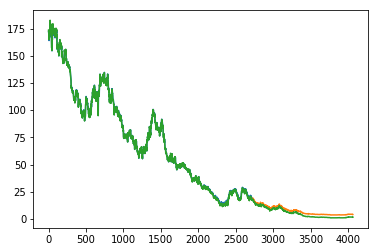

In [4]:

plt.plot(trainPredictPlot)
#plt.plot(trainPredict)
plt.plot(testPredictPlot)
#plt.plot(testPredict)
#plt.xlim(900,1400)
plt.plot( df_APPLE_[['Open']])

In [6]:
[trainPredictPlot,testPredictPlot]

[array([[      nan],
        [166.13255],
        [164.54985],
        ...,
        [      nan],
        [      nan],
        [      nan]], dtype=float32), array([[      nan],
        [      nan],
        [      nan],
        ...,
        [34.950504],
        [35.979916],
        [      nan]], dtype=float32)]

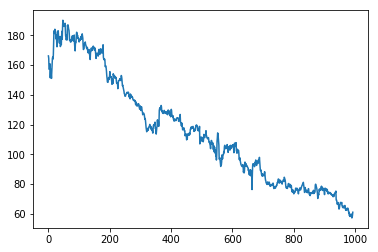

In [7]:
plt.plot(trainPredictPlot)

FB
   Unnamed: 0        Date    Open    High     Low   Close    Volume
0           0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1           1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2           2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3           3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4           4  2018-04-06  157.73  161.42  156.81  157.20  41644812
Index(['Date', ' Open', ' High', ' Low', ' Close', ' Volume'], dtype='object')
         Date    Open    High     Low   Close    Volume
0  2018-04-12  166.98  167.45  163.10  163.87  38262956
1  2018-04-11  165.36  168.65  163.25  166.32  56144633
2  2018-04-10  157.93  165.98  157.01  165.04  58947041
3  2018-04-09  157.82  160.53  156.04  157.93  34915227
4  2018-04-06  157.73  161.42  156.81  157.20  41644812
[[166.98]
 [165.36]
 [157.93]
 ...
 [ 32.61]
 [ 36.53]
 [ 42.05]]
Epoch 1/20
 - 7s - loss: 0.0578
Epoch 2/20
 - 4s - loss: 0.0029
Epoch 3/20
 - 4s - loss: 2.1994e-04
Epoch 4/

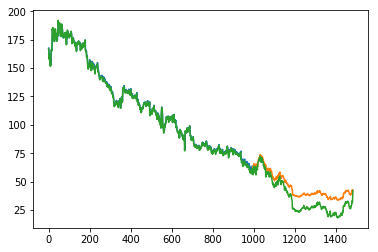

In [8]:
# LSTM model 2

df_FB = get_data('')
df_FB_ = col_fix(df_FB)
dataset = get_train_data(df_FB_)
dataset,trainPredict,testPredict,trainPredictPlot,testPredictPlot = one_input_LSTM_model_2(dataset)





plt.plot(trainPredictPlot)
#plt.plot(trainPredict)
plt.plot(testPredictPlot)
#plt.plot(testPredict)
#plt.xlim(900,1400)
plt.plot( df_FB_[['Open']])

In [9]:
for epoch in range(5):
    print (epoch)


0
1
2
3
4


In [10]:
dataset

array([[0.8559439 ],
       [0.84663147],
       [0.80392045],
       ...,
       [0.08352496],
       [0.10605887],
       [0.1377903 ]], dtype=float32)

In [12]:
#one_input_LSTM(dataset)

In [ ]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/20
 - 8s - loss: 0.0745
Epoch 2/20
 - 4s - loss: 0.0095
Epoch 3/20
 - 5s - loss: 0.0015
Epoch 4/20
 - 4s - loss: 2.5625e-04
Epoch 5/20
 - 4s - loss: 2.3283e-04
Epoch 6/20
 - 4s - loss: 2.2029e-04
Epoch 7/20
 - 4s - loss: 2.1845e-04
Epoch 8/20
 - 4s - loss: 2.0312e-04
Epoch 9/20
 - 4s - loss: 1.9782e-04
Epoch 10/20
 - 4s - loss: 1.8360e-04
Epoch 11/20
 - 4s - loss: 1.7804e-04
Epoch 12/20
 - 4s - loss: 1.7282e-04
Epoch 13/20


In [ ]:
trainX

In [ ]:
trainY

In [ ]:
train

In [ ]:
test

In [8]:

def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


def one_input_LSTM(dataset):
	# normalize the dataset
	scaler = MinMaxScaler(feature_range=(0, 1))
	dataset = scaler.fit_transform(dataset)
	# split into train and test sets
	train_size = int(len(dataset) * 0.67)
	test_size = len(dataset) - train_size
	train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
	# reshape into X=t and Y=t+1
	look_back = 1
	trainX, trainY = create_dataset(train, look_back)
	testX, testY = create_dataset(test, look_back)
	# reshape input to be [samples, time steps, features]
	trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
	testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
	# create and fit the LSTM network
	model = Sequential()
	model.add(LSTM(4, input_shape=(1, look_back)))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)
	# make predictions
	trainPredict = model.predict(trainX)
	testPredict = model.predict(testX)
	# invert predictions
	trainPredict = scaler.inverse_transform(trainPredict)
	trainY = scaler.inverse_transform([trainY])
	testPredict = scaler.inverse_transform(testPredict)
	testY = scaler.inverse_transform([testY])
	# calculate root mean squared error
	trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
	print('Train Score: %.2f RMSE' % (trainScore))
	testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
	print('Test Score: %.2f RMSE' % (testScore))
	# shift train predictions for plotting
	trainPredictPlot = np.empty_like(dataset)
	trainPredictPlot[:, :] = np.nan
	trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
	# shift test predictions for plotting
	testPredictPlot = np.empty_like(dataset)
	testPredictPlot[:, :] = np.nan
	testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict


In [5]:
df_APPLE_[['Open','Open']].values.astype('float32')

array([[173.41  , 173.41  ],
       [172.23  , 172.23  ],
       [173.    , 173.    ],
       ...,
       [  1.5357,   1.5357],
       [  1.6521,   1.6521],
       [  1.6157,   1.6157]], dtype=float32)

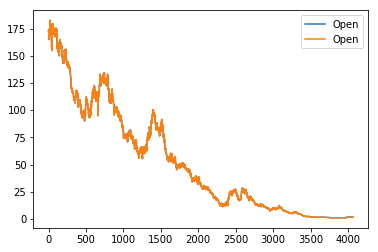

In [9]:
df_APPLE_[['Open','Open']].plot()

In [6]:
df_APPLE_.head(3)

,Date,Open,High,Low,Close,Volume
0,2018-04-12,173.41,175.0000,173.04,174.14,22889285
1,2018-04-11,172.23,173.9232,171.70,172.44,22431640
2,2018-04-10,173.00,174.0000,171.53,173.25,28614241


In [7]:
df_APPLE_['Open'].values.astype('float32')

array([173.41  , 172.23  , 173.    , ...,   1.5357,   1.6521,   1.6157],
      dtype=float32)